In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import os

# Folder for audio files
os.makedirs("audio_data", exist_ok=True)

In [90]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def extract_features(
    file_path,
    sr=16000
):
    """
    Returns MFCC / delta / delta-delta using only the selected low-order coefficients.
    """
    n_mfcc_total=50
    keep=8
    drop_c0=True
    
    y, sr = librosa.load(file_path, sr=sr)
    mfcc_all = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_total)

    start = 1 if drop_c0 else 0
    stop = start + keep
    mfcc = mfcc_all[start:stop, :]              # shape: (keep, frames)

    delta  = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    used_indices = list(range(start, stop))     # e.g., [1..8]
    return mfcc, delta, delta2, sr, used_indices

def _delta_per_second(delta, sr, hop_length):
    """Convert frame-to-frame delta to per-second units."""
    frames_per_second = sr / float(hop_length)
    return delta * frames_per_second

def _symmetric_limits(X):
    """Symmetric color limits around 0 for diverging colormaps."""
    m = np.nanmax(np.abs(X))
    if not np.isfinite(m) or m == 0:
        m = 1.0
    return -m, m

def summarize_deltas(delta_ps, used_indices):
    """Return a human-readable summary per coefficient."""
    # % time increasing, % time decreasing, mean |rate| in units / s
    signs = np.sign(delta_ps)
    inc_pct = (signs > 0).mean(axis=1) * 100.0
    dec_pct = (signs < 0).mean(axis=1) * 100.0
    mean_rate = np.mean(np.abs(delta_ps), axis=1)
    lines = []
    for i, (p_inc, p_dec, mr) in enumerate(zip(inc_pct, dec_pct, mean_rate)):
        lines.append(f"c{used_indices[i]}: ↑ {p_inc:5.1f}%  ↓ {p_dec:5.1f}%   avg |Δ| {mr:7.3f} units/s")
    return "\n".join(lines)

def plot_features(
    mfcc, delta, delta2, sr, used_indices,
    hop_length=512, title_prefix="", vmin=None, vmax=None
):
    """
    Plots MFCC / delta / delta-delta with clearer delta interpretation.
    - MFCC: unchanged.
    - Delta/Delta-Delta: per-second units, symmetric color scale, diverging colormap.
    """
    # Convert deltas to per-second change for human-readable rates
    delta_ps  = _delta_per_second(delta,  sr, hop_length)
    delta2_ps = _delta_per_second(delta2, sr, hop_length)

    d_vmin, d_vmax   = _symmetric_limits(delta_ps)
    d2_vmin, d2_vmax = _symmetric_limits(delta2_ps)

    # Build a concise text summary for the console/log
    summary = summarize_deltas(delta_ps, used_indices)
    print("\nDelta summary (per coefficient):")
    print("  ↑ = increasing frames, ↓ = decreasing frames, avg |Δ| = average absolute change rate")
    print(summary)

    plt.figure(figsize=(14, 9))

    # --- MFCC (unchanged) ---
    plt.subplot(3, 1, 1)
    librosa.display.specshow(
        mfcc, x_axis='time', sr=sr, hop_length=hop_length,
        vmin=vmin, vmax=vmax
    )
    plt.yticks(range(len(used_indices)), labels=[f"c{idx}" for idx in used_indices])
    plt.colorbar(label='MFCC value')
    plt.title(f"{title_prefix} MFCC")
    plt.ylabel("Coefficient")

    # --- Delta (1st derivative, per second) ---
    plt.subplot(3, 1, 2)
    librosa.display.specshow(
        delta_ps, x_axis='time', sr=sr, hop_length=hop_length,
        cmap='RdBu_r', vmin=d_vmin, vmax=d_vmax
    )
    plt.yticks(range(len(used_indices)), labels=[f"c{idx}" for idx in used_indices])
    cb = plt.colorbar(label='Δ MFCC per second')
    plt.title(f"{title_prefix} Delta (1st derivative) — negative = decreasing, positive = increasing")
    plt.ylabel("Coefficient")

    # --- Delta-Delta (2nd derivative, per second^2) ---
    plt.subplot(3, 1, 3)
    librosa.display.specshow(
        delta2_ps, x_axis='time', sr=sr, hop_length=hop_length,
        cmap='RdBu_r', vmin=d2_vmin, vmax=d2_vmax
    )
    plt.yticks(range(len(used_indices)), labels=[f"c{idx}" for idx in used_indices])
    plt.colorbar(label='Δ² MFCC per second²')
    plt.title(f"{title_prefix} Delta-Delta (2nd derivative) — negative = decelerating, positive = accelerating")
    plt.ylabel("Coefficient")

    plt.tight_layout()
    plt.show()


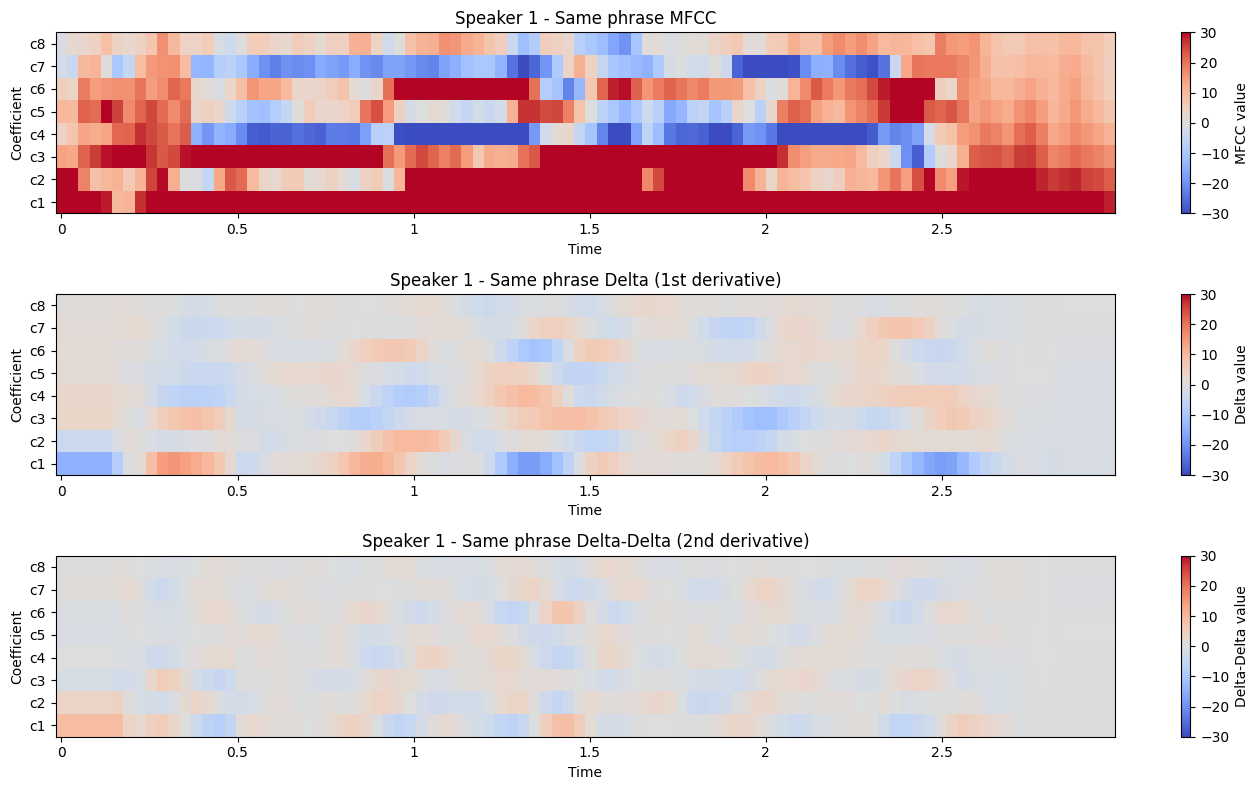

In [99]:
file_path = "audio_data/stefan_same_intonation_same_speed.wav"

# Extract features (classic: keep c1..c12, drop c0)
mfcc, delta, delta2, sr, idx = extract_features(file_path)

# Plot with fixed color scale for better speaker comparison
plot_features(
    mfcc, delta, delta2, sr, idx,
    title_prefix="Speaker 1 - Same phrase",
    vmin=-30, vmax=30
)


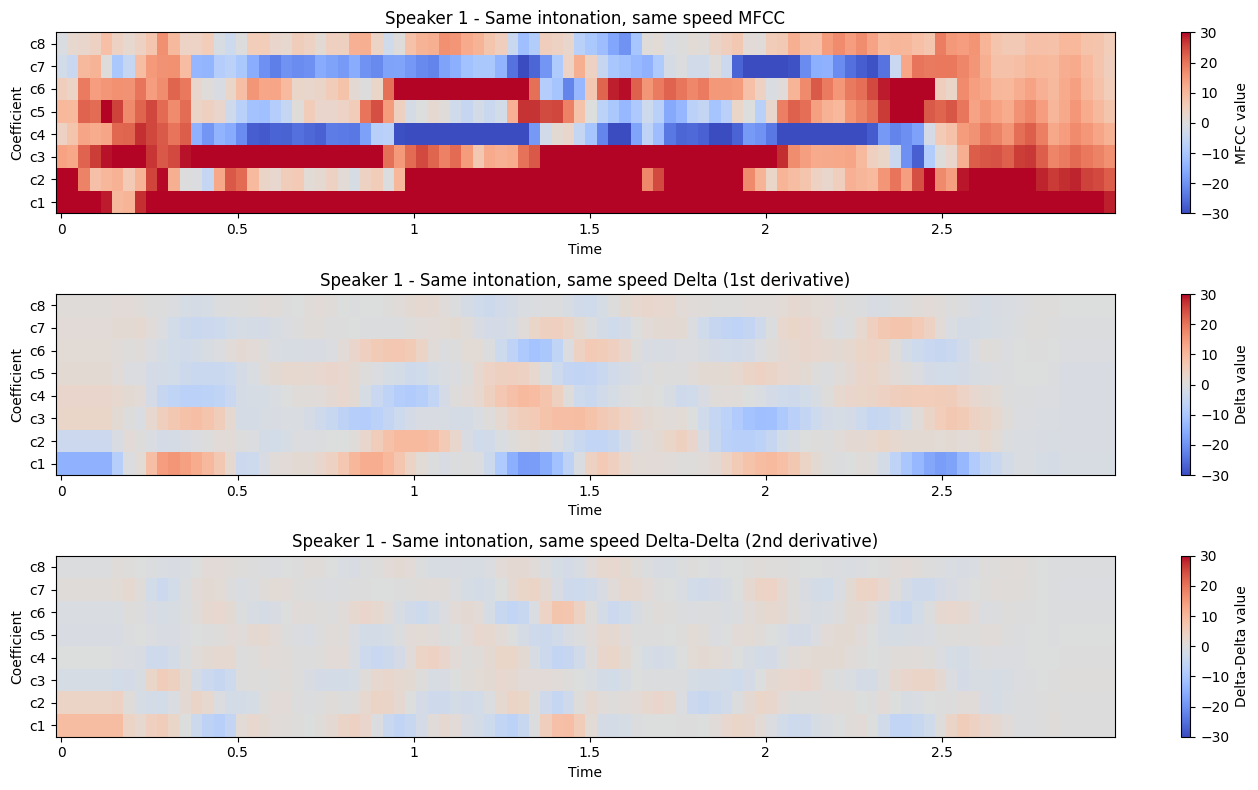

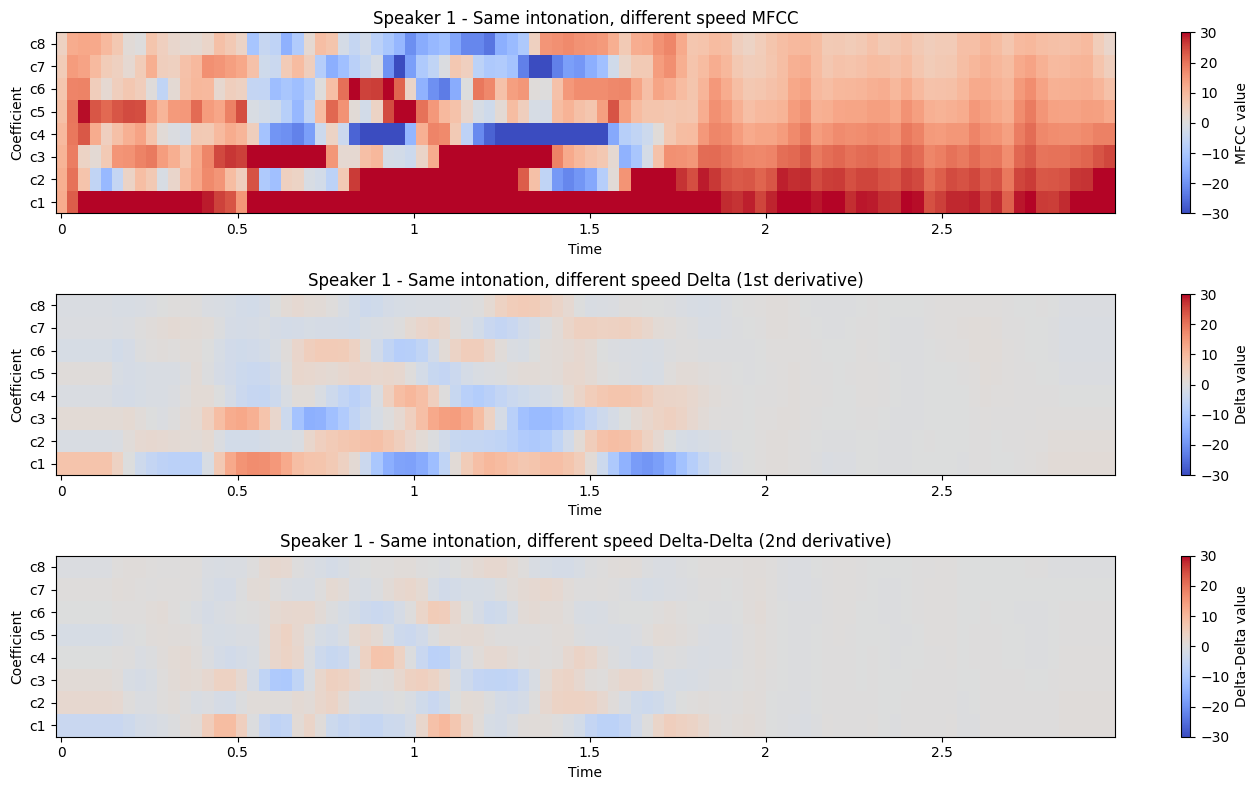

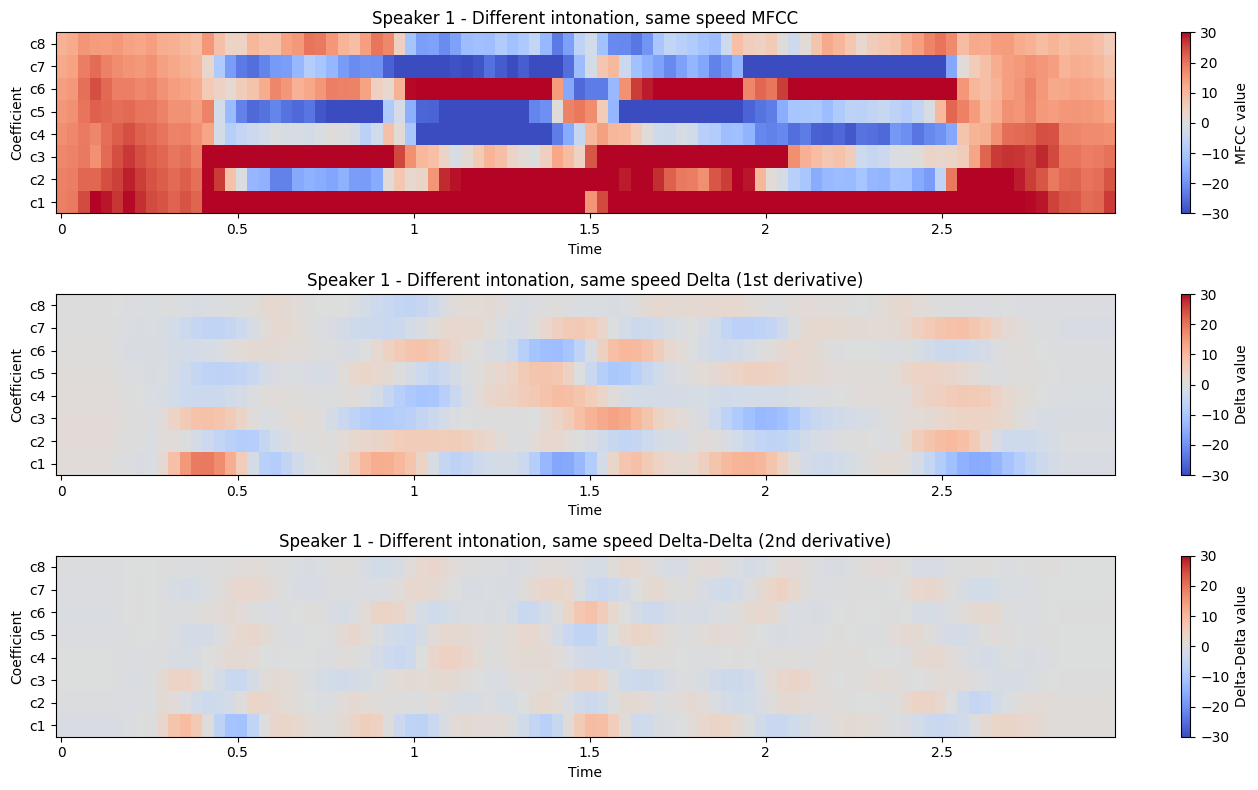

In [ ]:
files = [
    ("audio_data/stefan_same_intonation_same_speed.wav", "Same intonation, same speed"),
    ("audio_data/stefan_same_intonation_diff_speed.wav", "Same intonation, different speed"),
    ("audio_data/stefan_diff_intonation_same_speed.wav", "Different intonation, same speed"),
]

# Fixed color scale for fair comparison (tweak if needed)
VMIN, VMAX = -30, 30

for path, desc in files:
    mfcc, delta, delta2, sr, idx = extract_features(path)
    plot_features(
        mfcc, delta, delta2, sr, idx,
        title_prefix=f"Speaker 1 - {desc}",
        vmin=VMIN, vmax=VMAX
    )


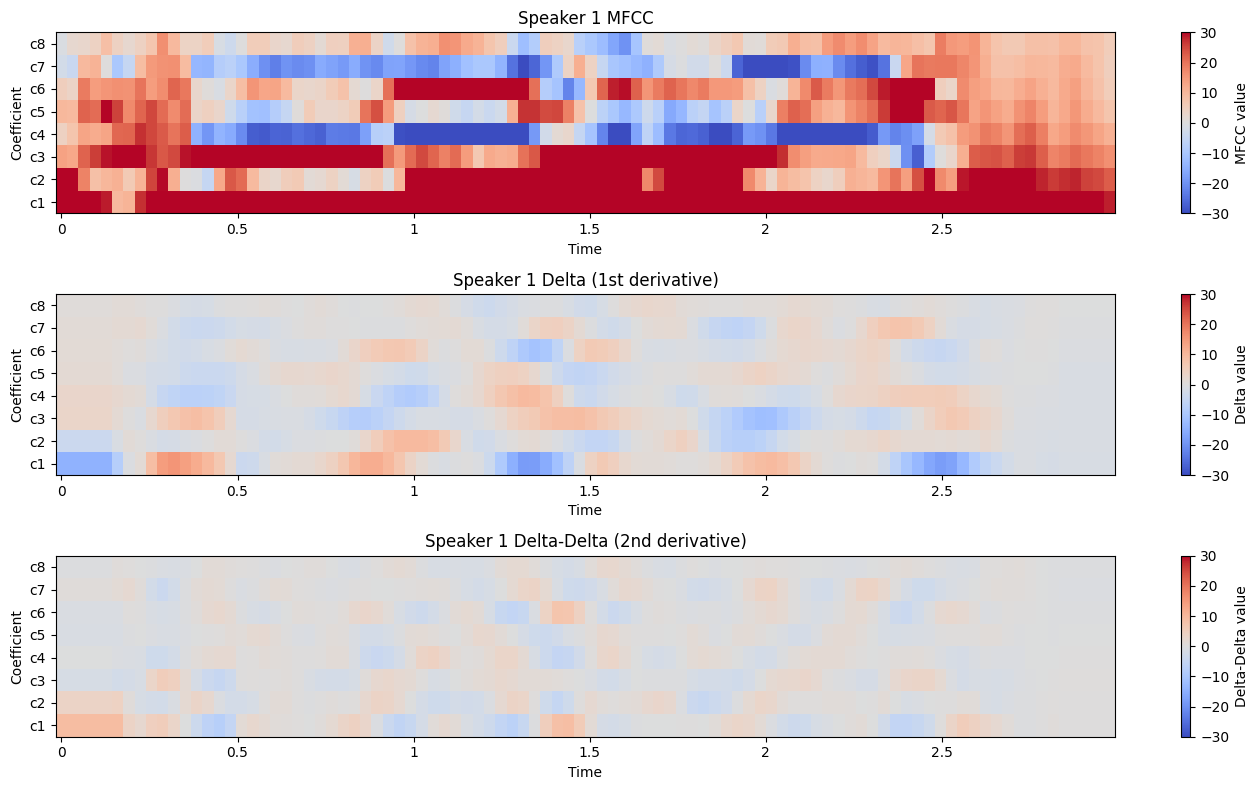

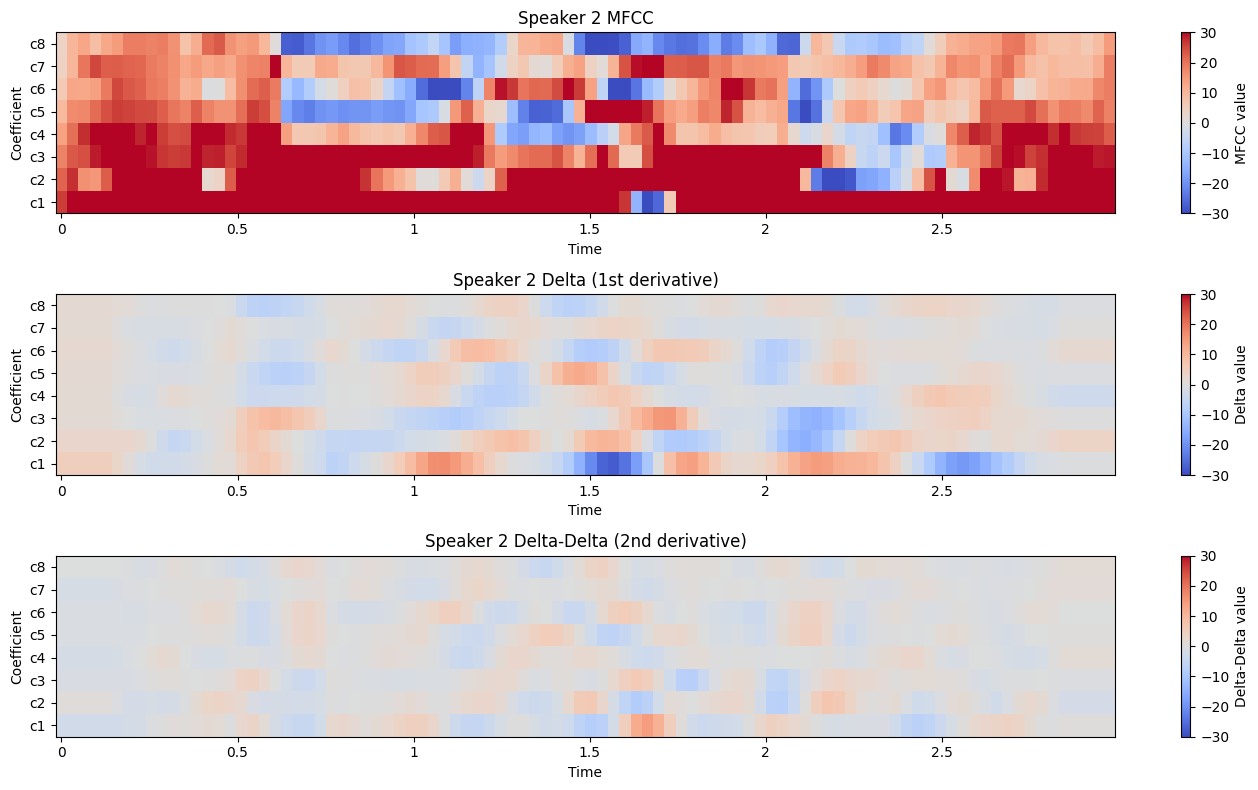

In [100]:
files = [
    ("audio_data/stefan_same_intonation_same_speed.wav", "Speaker 1"),
    ("audio_data/martin_same_intonation_same_speed.wav", "Speaker 2"),
]

# Fixed color scale for comparison
VMIN, VMAX = -30, 30

for path, desc in files:
    mfcc, delta, delta2, sr, idx = extract_features(path)
    plot_features(
        mfcc, delta, delta2, sr, idx,
        title_prefix=desc,
        vmin=VMIN, vmax=VMAX
    )


## Analiza — ponovljivost pri istem govorcu

- **Najbolj stabilni:** nizki MFCC (npr. c1–c8), saj opisujejo osnovno porazdelitev energije.
- **Manj stabilni:** delta in delta-delta, ker merijo spremembe skozi čas in so občutljive na hitrost, ritem in manjše razlike v izgovoru.

## Analiza — razlike med govorci

- **Največje razlike:** nizki MFCC (c1–c3), včasih tudi delta.
- **Vzroki:** fiziološke razlike (višina glasu, resonanca), artikulacija, naglas in ritem govora.
